Mount google drive containing NASA data

In [1]:
!pip install google
from google.colab import drive
drive.mount('/content/gdrive')
GOOGLEDRIVER_DIR = r'/content/gdrive/My Drive/nasa/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import of libraries

In [0]:

import pandas as pd
import matplotlib.pyplot as plt

import calendar
from datetime import datetime

# Import Facebook's Prophet forecasting library
from fbprophet import Prophet


**Dataset used to predict temperture and level of ocean rising**

In [0]:
#file GMSL.csv(global media of sea level) created with data from the link below:
#https://podaac-tools.jpl.nasa.gov/drive/files/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level
dados_gmsl = pd.read_csv(GOOGLEDRIVER_DIR + r'GMSL.csv',delimiter=',')

#file GLBT.csv(global temperatura) created with data from the link below:
#https://data.giss.nasa.gov/gistemp/
dados_glbt = pd.read_csv(GOOGLEDRIVER_DIR + r'GLB.Ts+dSST.csv',delimiter=',')

#some codes here were based on https://towardsdatascience.com/time-series-analysis-and-climate-change-7bb4371021e

Plot ocean level data from NASA dataset

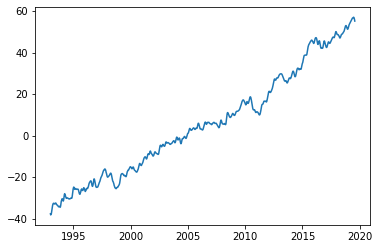

In [5]:
_ = plt.plot(dados_gmsl['timestamp'], dados_gmsl['smoothed3'])

Plot average temperature rise between January and February by year

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



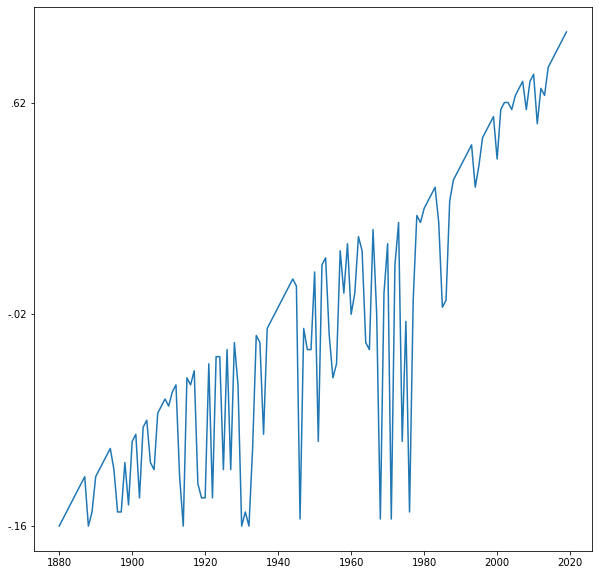

In [15]:
#define figure size
plt.figure(figsize=(5,10))

#plot data
_ = plt.plot(dados_glbt['Year'], 
             dados_glbt['J-D'])

#get axes from plot
ax = plt.axes()

#set the number of ticks
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

Prepare data format to forecast 100 years

In [0]:
# Create new dataframe with an index for each month
# First create the date range
date_rng = pd.date_range(start='1/1/1880', end='1/10/2019', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# Next create the empty DataFrame, which we will populate using the actual data
t = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the anomoly values
t['Avg_Anomaly_deg_C'] = None

# Set the index of the DataFrame to the date column (DateTime index)
t.set_index('date', inplace=True)

# Show the first few elements
t.head()



# Function definition
def populate_df_with_anomolies_from_row(row):
    year = row['Year']
    # Anomaly values (they seem to be a mixture of strings and floats)
    monthly_anomolies = row.iloc[1:]
    # Abbreviated month names (index names)
    months = monthly_anomolies.index
    for month in monthly_anomolies.index:
        # Get the last day for each month 
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate) 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # Populate / set value @ above index, to anomaly value
        t.loc[date_index] = monthly_anomolies[month]

# Apply function to each row of raw data 
_ = raw_t.apply(lambda row: populate_df_with_anomolies_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
t.head()




,Avg_Anomaly_deg_C
date,
1880-01-31,-0.17
1880-02-29,-0.24
1880-03-31,-0.09
1880-04-30,-0.15
1880-05-31,-0.09


In [0]:
# Import Numpy, a library meant for large arrays - we will use it for its NaN representation 
import numpy as np

# Define function to convert values to floats, and return a 'NaN = Not a Number' if this is not possible
def clean_anomaly_value(raw_value):
    try:
        return float(raw_value)
    except:
        return np.NaN
    
# Apply above function to all anomaly values in DataFrame
t['Avg_Anomaly_deg_C'] = t['Avg_Anomaly_deg_C'].apply(lambda raw_value: clean_anomaly_value(raw_value))

# 'Forward fill' to take care of NaN values
t.fillna(method='ffill', inplace=True)

# Show the first few elements of our newly cleaned DataFrame
t.head()

,Avg_Anomaly_deg_C
date,
1880-01-31,-0.17
1880-02-29,-0.24
1880-03-31,-0.09
1880-04-30,-0.15
1880-05-31,-0.09


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


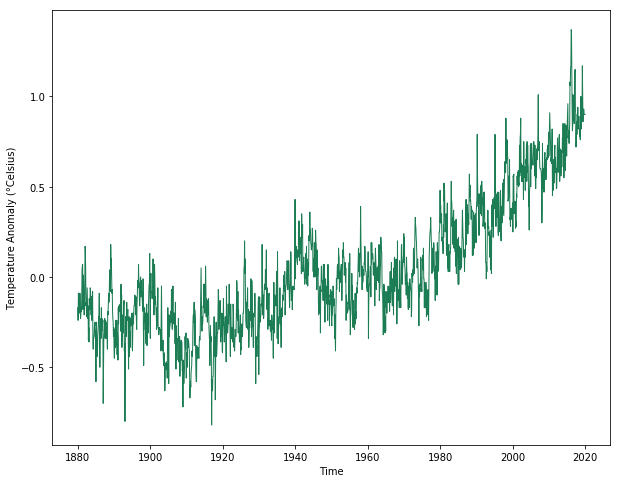

In [0]:
# Allow for rendering within notebook
%matplotlib inline

# Create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t, color='#1C7C54', linewidth=1.0)

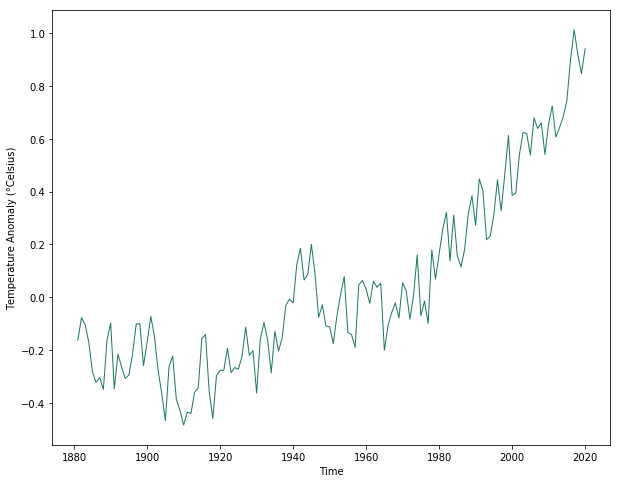

In [0]:
# Now lets visualize our resampled DataFrame

# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t.resample('A').mean(), color='#1C7C54', linewidth=1.0)

Predict 100 years data for Temperature data using fbphrophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


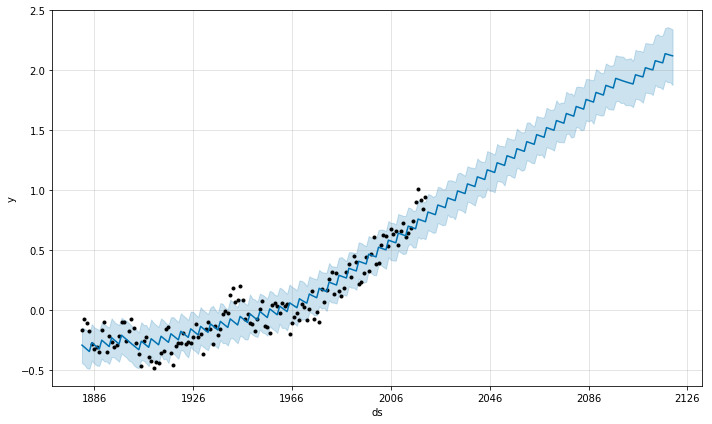

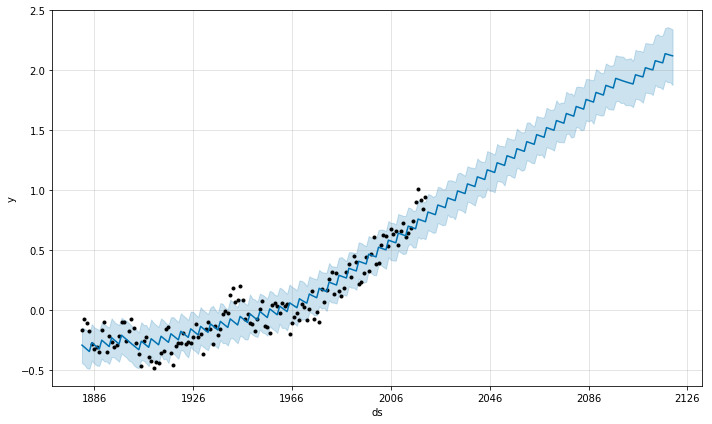

In [0]:


t_ = t.resample('A').mean()

# Create a new DataFrame with which we will create/train our Prophet model 
t_prophet = pd.DataFrame()
t_prophet['ds'] = t_.index
t_prophet['y'] = t_['Avg_Anomaly_deg_C'].values



# Instantiate model and fit to data (just like with sklearn model API)
m = Prophet()
m.fit(t_prophet)

# Generate future dataframe containing predictions (we are doing this for 100 years into the future)
future = m.make_future_dataframe(freq='A', periods=100)
forecast = m.predict(future)

# Plot the resulting forecast
m.plot(forecast)

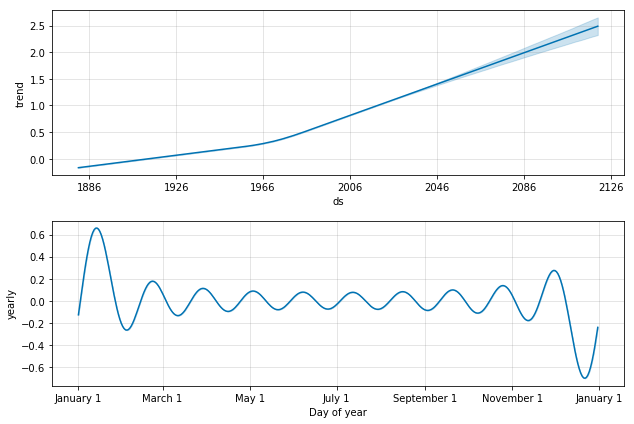

In [0]:
# Plot the forecast components
m.plot_components(forecast)

Prepare ocean level data for prediction

In [0]:
#plt.plot(dados_gmsl['timestamp'], dados_gmsl['smoothed3'])
dados_gmsl[["Year"]] = dados_gmsl[["timestamp"]].fillna(0.0).astype(int)

In [0]:
gmsl_by_year = dados_gmsl.groupby(['Year'])['smoothed3'].max().reset_index()
gmsl_by_year['timestamp'] = pd.to_datetime(dict(year=gmsl_by_year.Year, month=12, day=31))



Predict ocean level for 100 years

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.


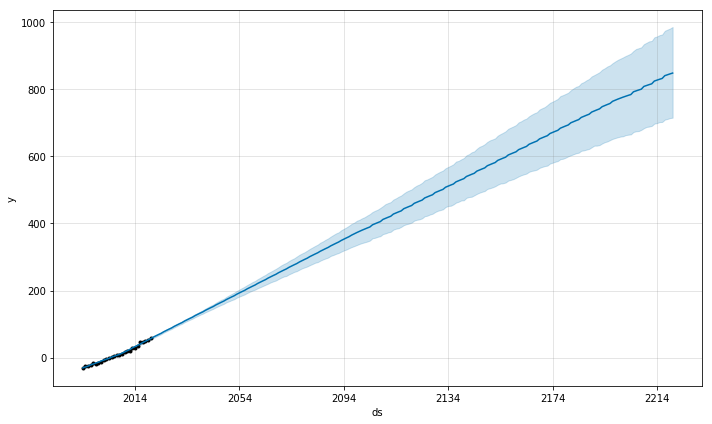

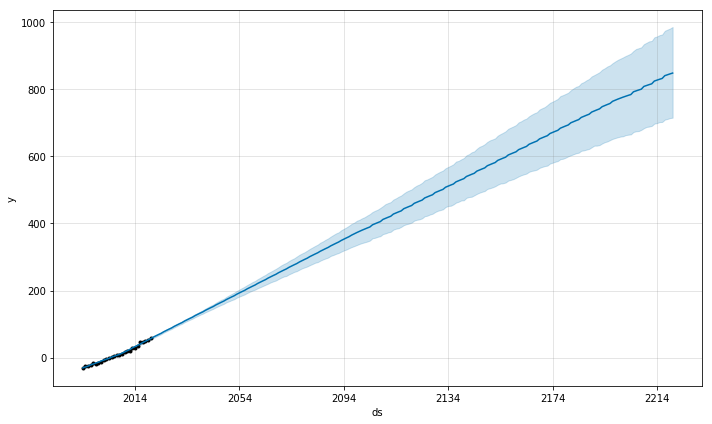

In [0]:
# Import Facebook's Prophet forecasting library
from fbprophet import Prophet

# Create a new DataFrame with which we will create/train our Prophet model 
t_prophet = pd.DataFrame()
t_prophet['ds'] = gmsl_by_year['timestamp'].values
t_prophet['y'] = gmsl_by_year['smoothed3'].values



# Instantiate model and fit to data (just like with sklearn model API)
m = Prophet()
m.fit(t_prophet)

# Generate future dataframe containing predictions (we are doing this for 100 years into the future)
future = m.make_future_dataframe(freq='A', periods=200)
forecast = m.predict(future)

# Plot the resulting forecast
m.plot(forecast)

In [0]:
forecast.yhat[126]

453.42739085956407

In [0]:
gmsl_by_year

,Year,smoothed3,timestamp
0,1993,-31.01,1993-12-31
1,1994,-25.61,1994-12-31
2,1995,-24.65,1995-12-31
3,1996,-20.76,1996-12-31
4,1997,-16.03,1997-12-31
5,1998,-17.97,1998-12-31
6,1999,-14.86,1999-12-31
7,2000,-13.27,2000-12-31
8,2001,-7.29,2001-12-31
9,2002,-4.11,2002-12-31
